In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb(pretty=True)

In [2]:
import time
import jax
import os
import pickle
import numpy as np
import jax.numpy as jnp
import scipy.spatial
import matplotlib.pyplot as plt
from confirm.mini_imprint import grid
from confirm.lewislib import grid as lewgrid
from confirm.lewislib import lewis, batch
from confirm.mini_imprint import binomial

import lewis_tune_sim as lts

from rich import print as rprint

In [3]:
# Configuration used during simulation
name = "4d"
params = {
    "n_arms": 4,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}


In [4]:
# Configuration used during simulation
name = "3d"
params = {
    "n_arms": 3,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}

In [5]:

lei_obj = lewis.Lewis45(**params)
n_arm_samples = int(lei_obj.unifs_shape()[0])

In [6]:
n_arms = params["n_arms"]
ns = np.concatenate(
    [np.ones(n_arms - 1)[:, None], -np.eye(n_arms - 1)],
    axis=-1,
)
null_hypos = [grid.HyperPlane(n, 0) for n in ns]
symmetry = []
for i in range(n_arms - 2):
    n = np.zeros(n_arms)
    n[i + 1] = 1
    n[i + 2] = -1
    symmetry.append(grid.HyperPlane(n, 0))

theta_min = -2.0
theta_max = 2.0
init_grid_size = 8
theta, radii = grid.cartesian_gridpts(
    np.full(n_arms, theta_min),
    np.full(n_arms, theta_max),
    np.full(n_arms, init_grid_size),
)
g_raw = grid.build_grid(theta, radii)

In [7]:
target_grid_cost = 0.0002
target_sim_cost = 0.001
target_alpha = 0.025
holderq = 6
delta_validate = 0.01

grid_batch_size = 2**6 if jax.devices()[0].device_kind == "cpu" else 2**10
max_sim_size = 2**17
init_nsims = 2000
seed = 0
key = jax.random.PRNGKey(seed)

unifs = jax.random.uniform(key=key, shape=(max_sim_size,) + lei_obj.unifs_shape())
unifs_order = np.arange(0, unifs.shape[1])

batched_tune = lts.grouped_by_sim_size(lei_obj, lts.tunev, grid_batch_size)
batched_rej = lts.grouped_by_sim_size(lei_obj, lts.rejv, grid_batch_size)


In [45]:

batched_invert_bound = batch.batch_all_concat(
    lambda *args: (binomial.invert_bound(*args),),
    grid_batch_size,
    in_axes=(None, 0, 0, None, None),
)

In [61]:
load_iter = 'latest'
if load_iter == 0:
    g = grid.build_grid(
        theta, radii, null_hypos=null_hypos, symmetry_planes=symmetry, should_prune=True
    )
    sim_sizes = np.full(g.n_tiles, init_nsims)
    sim_cvs = np.empty(g.n_tiles, dtype=float)
    pointwise_target_alpha = np.empty(g.n_tiles, dtype=float)
    todo = np.ones(g.n_tiles, dtype=bool)
else:
    if load_iter == 'latest':
        # find the file with the largest checkpoint index: name/###.pkl 
        load_iter = max([int(fn[:-4]) for fn in os.listdir(name) if re.match(r'[0-9]+.pkl', fn)])
    fn = f"{name}/{load_iter}.pkl"
    print(f'loading checkpoint {fn}')
    with open(fn, "rb") as f:
        (
            g,
            sim_sizes,
            sim_cvs,
            typeI_sum,
            hob_upper,
            pointwise_target_alpha,
        ) = pickle.load(f)
    todo = np.zeros(g.n_tiles, dtype=bool)
    todo[-1] = True
# TODO: remove
typeI_sum = None
hob_upper = None

loading checkpoint 3d/101.pkl


In [62]:
todo[:] = True

In [63]:
adafrac = 1.10
iter_max = 1000
cost_per_sim = 500e-9
for II in range(load_iter + 1, iter_max):
    if np.sum(todo) == 0:
        break

    print(f"starting iteration {II} with {np.sum(todo)} tiles to process")
    if cost_per_sim is not None:
        predicted_time = np.sum(sim_sizes[todo] * cost_per_sim)
        print(f'runtime prediction: {predicted_time:.2f} seconds')

    start = time.time()
    pointwise_target_alpha[todo] = batched_invert_bound(
        target_alpha, g.theta_tiles[todo], g.vertices[todo], n_arm_samples, holderq
    )[0]
    print("inverting the bound took", time.time() - start)
    start = time.time()

    sim_cvs[todo] = batched_tune(
        sim_sizes[todo],
        (pointwise_target_alpha[todo],
        g.theta_tiles[todo],
        g.null_truth[todo],),
        unifs,
        unifs_order,
    )
    worst_tile = np.argmin(sim_cvs)
    overall_cv = np.min(sim_cvs)
    cost_per_sim = min((time.time() - start) / np.sum(sim_sizes[todo]), 500e-9)
    todo[:] = False
    print("tuning took", time.time() - start)

    savedata = [g, sim_sizes, sim_cvs, None, None, pointwise_target_alpha]
    with open(f"{name}/{II}.pkl", "wb") as f:
        pickle.dump(savedata, f)


    hob_theory_cost = target_alpha - pointwise_target_alpha
    which_refine = (sim_cvs <= adafrac * overall_cv) & (
        hob_theory_cost > target_grid_cost
    )
    impossible_alpha = np.floor(pointwise_target_alpha * (sim_sizes + 1)) - 1 <= 0
    which_refine |= impossible_alpha

    report = dict(
        II=II,
        overall_cv=overall_cv,
        n_tiles=g.n_tiles,
        n_refine=np.sum(which_refine),
        n_refine_impossible=np.sum(impossible_alpha),
        grid_cost=f"{hob_theory_cost[worst_tile]:.4f}",
    )
    rprint(report)

    if (np.sum(which_refine) > 0) and II != iter_max - 1:

        refine_tile_idxs = np.where(which_refine)[0]
        refine_gridpt_idxs = g.grid_pt_idx[refine_tile_idxs]
        new_thetas, new_radii, unrefined_grid, keep_tile_idxs = grid.refine_grid(
            g, refine_gridpt_idxs
        )
        new_grid = grid.build_grid(
            new_thetas,
            new_radii,
            null_hypos=g.null_hypos,
            symmetry_planes=symmetry,
            should_prune=True,
        )
        nearest_parent_tiles = scipy.spatial.KDTree(g.theta_tiles).query(
            new_grid.theta_tiles, k=2
        )
        new_sim_sizes = np.max(sim_sizes[nearest_parent_tiles[1]], axis=1).astype(int)

        old_g = g
        g = grid.concat_grids(unrefined_grid, new_grid)

        sim_sizes = np.concatenate([sim_sizes[keep_tile_idxs], new_sim_sizes])
        todo = np.concatenate(
            [todo[keep_tile_idxs], np.ones(new_grid.n_tiles, dtype=bool)]
        )
        sim_cvs = np.concatenate(
            [sim_cvs[keep_tile_idxs], np.zeros(new_grid.n_tiles, dtype=float)]
        )
        pointwise_target_alpha = np.concatenate(
            [
                pointwise_target_alpha[keep_tile_idxs],
                np.empty(new_grid.n_tiles, dtype=float),
            ]
        )
        continue
    print("done!")
    break

starting iteration 102 with 4721515 tiles to process
inverting the bound took 5.312893867492676


In [46]:

    # typeI_sum[todo] = batched_sim(
    #     sim_sizes[todo],
    #     np.full(todo.sum(), overall_cv),
    #     g.theta_tiles[todo],
    #     g.null_truth[todo],
    #     unifs,
    #     unifs_order,
    # )
    # import pickle

    # typeI_est, typeI_CI = binomial.zero_order_bound(
    #     typeI_sum, sim_sizes, delta_validate, 1.0
    # )
    # typeI_bound = typeI_est + typeI_CI
    # hob_upper = binomial.holder_odi_bound(
    #     typeI_bound, g.theta_tiles, g.vertices, n_arm_samples, holderq
    # )
    # sim_cost = typeI_CI
    # hob_empirical_cost = hob_upper - typeI_bound
    # which_refine = (
    #     hob_theory_cost > max(adafrac * hob_theory_cost[worst_tile], target_grid_cost)
    # ) & (
    #     (hob_upper > adafrac * hob_upper[worst_tile]) | (sim_cvs == sim_cvs[worst_tile])
    # )
    # which_more_sims = (
    #     typeI_CI > max(adafrac * typeI_CI[worst_tile], target_sim_cost)
    # ) & (
    #     (typeI_bound > adafrac * hob_upper[worst_tile])
    #     | (sim_cvs == sim_cvs[worst_tile])
    # )
        #
        # n_more_sims=np.sum(which_more_sims),
        # sim_cost=f"{sim_cost[worst_tile]:.4f}",
        #
        # sim_sizes[which_more_sims] *= 2
        # todo[which_more_sims] = True
        # typeI_sum = np.concatenate(
        #     [typeI_sum[keep_tile_idxs], np.zeros(new_grid.n_tiles, dtype=float)]
        # )
        # hob_upper = np.concatenate(
        #     [hob_upper[keep_tile_idxs], np.empty(new_grid.n_tiles, dtype=float)]
        # )
typeI_sum = batched_rej(
    sim_sizes,
    (np.full(sim_sizes.shape[0], overall_cv),
    g.theta_tiles,
    g.null_truth,),
    unifs,
    unifs_order,
)

typeI_est, typeI_CI = binomial.zero_order_bound(
    typeI_sum, sim_sizes, delta_validate, 1.0
)
typeI_bound = typeI_est + typeI_CI

hob_upper = binomial.holder_odi_bound(
    typeI_bound, g.theta_tiles, g.vertices, n_arm_samples, holderq
)
sim_cost = typeI_CI
hob_empirical_cost = hob_upper - typeI_bound

running for size 1000 with 389189 tiles took 129.48086714744568


In [47]:
savedata = [
    g,
    sim_sizes,
    sim_cvs,
    typeI_sum,
    hob_upper,
    pointwise_target_alpha
]
with open(f"{name}/final.pkl", "wb") as f:
    pickle.dump(savedata, f)

In [48]:
worst_idx = np.argmax(typeI_est)
worst_tile = g.theta_tiles[worst_idx]
typeI_est[worst_idx], worst_tile

(0.023, array([ 0.61279297, -0.99560547,  0.61279297]))

In [49]:
worst_cv_idx = np.argmin(sim_cvs)
typeI_est[worst_cv_idx], sim_cvs[worst_cv_idx], g.theta_tiles[worst_cv_idx], pointwise_target_alpha[worst_cv_idx]

(0.023,
 0.07458076881438402,
 array([ 0.61279297, -0.99560547,  0.61279297]),
 0.02408445767033002)

In [43]:
np.sum((sim_cvs <= adafrac * overall_cv) & (hob_theory_cost > target_grid_cost))

56

In [38]:
hob_theory_cost[worst_cv_idx]

0.018794773783568718

In [36]:
1.1 * overall_cv

0.024925544805611037

In [17]:
pointwise_target_alpha[worst_idx]

0.02138854141734557

In [49]:
idxs = [worst_idx]
batched_sim(
    sim_sizes[idxs],
    np.full(1, sim_cvs[idxs]),
    g.theta_tiles[idxs],
    g.null_truth[idxs],
    unifs,
    unifs_order,
) / sim_sizes[idxs]

running for size 2000 with 1 tiles took 0.934185266494751


array([0.1145])

19041


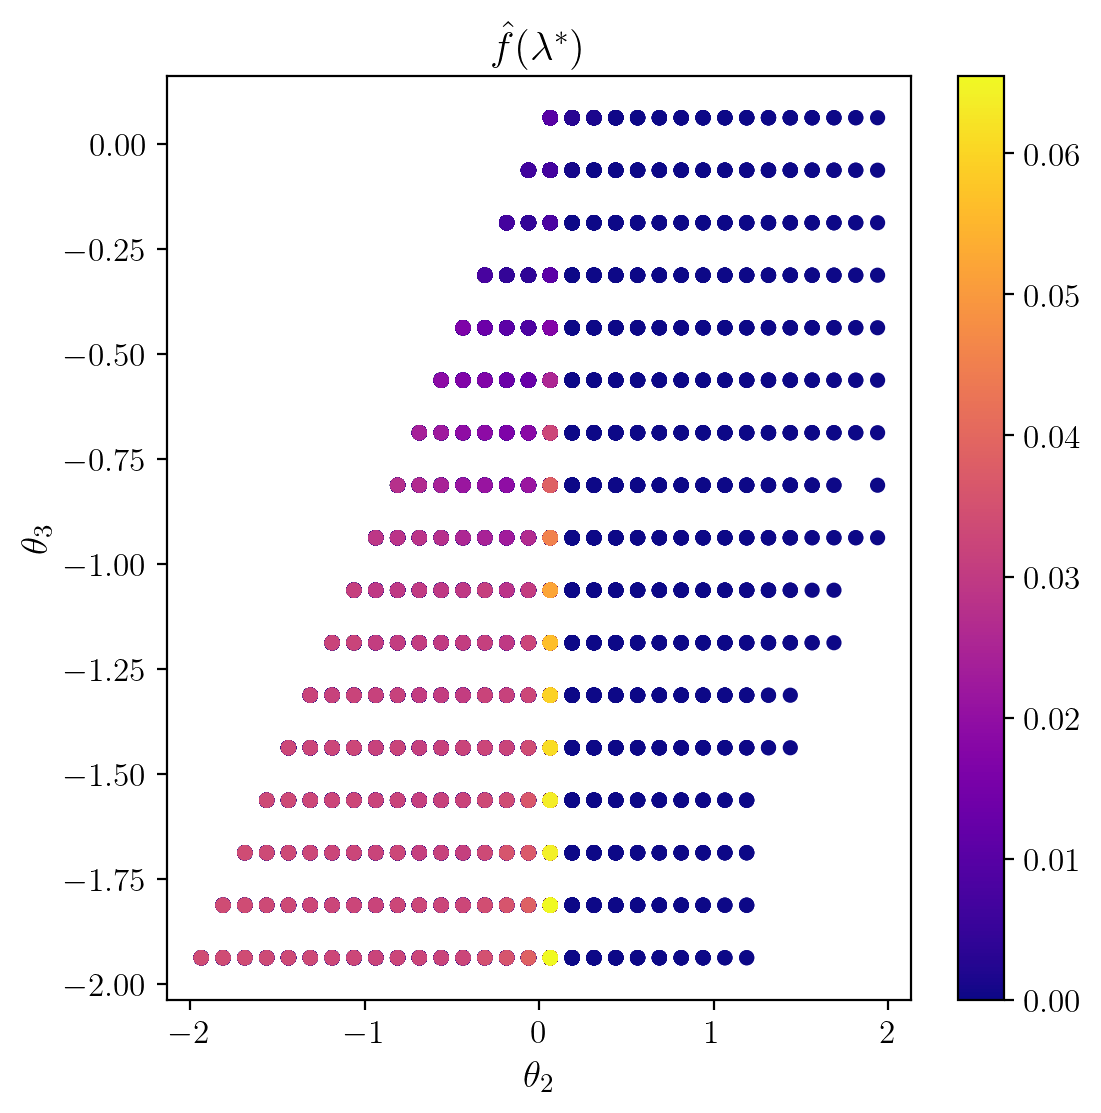

22265


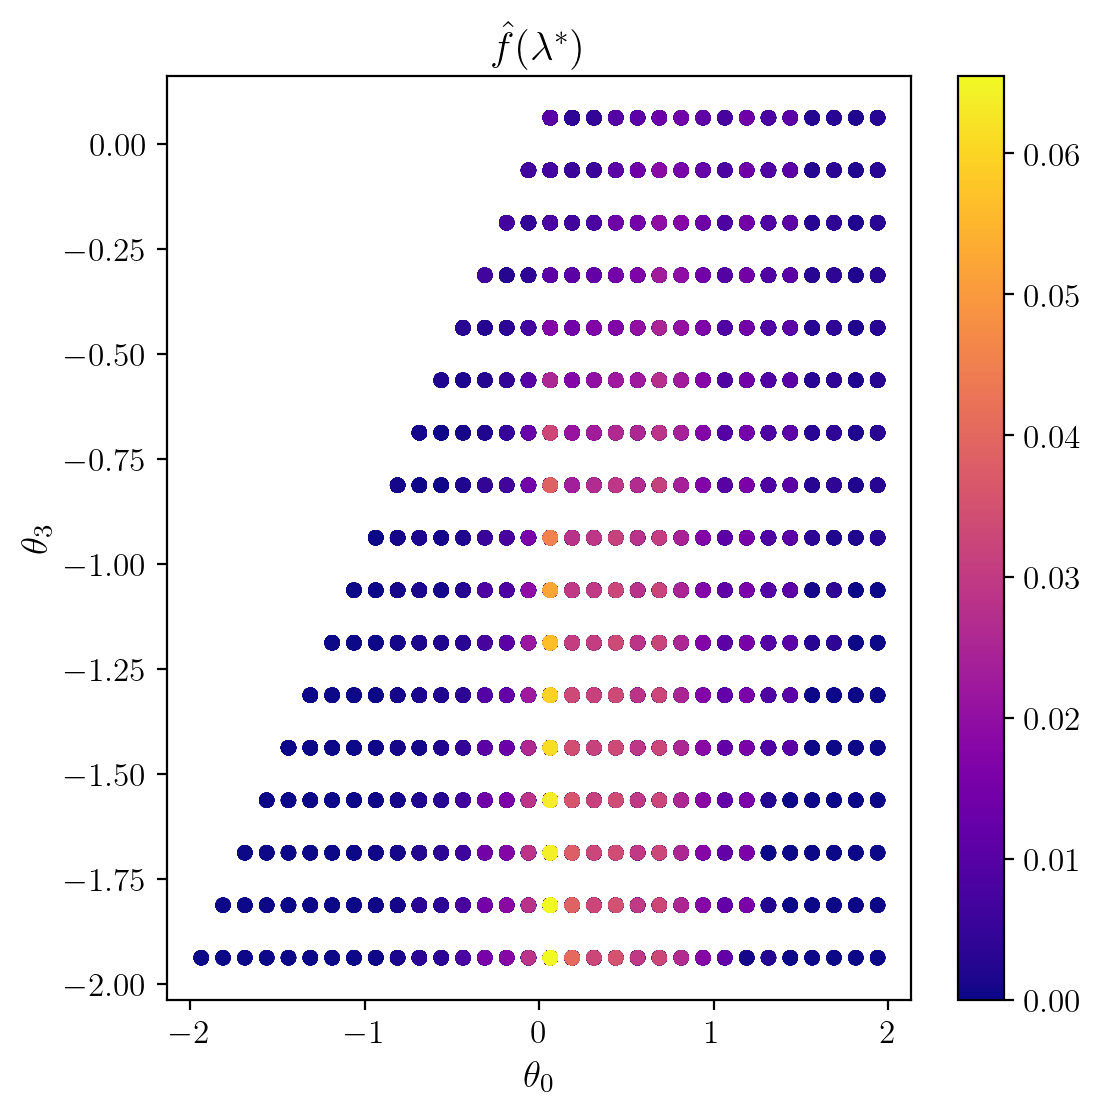

In [39]:
def pandemonium(field):
    for unplot_set in [{0, 1}, {1, 2}]:
        plot = list(set(range(n_arms)) - unplot_set)
        unplot = list(unplot_set)
        select = np.where(np.all(np.abs(g.theta_tiles[:, unplot] - worst_tile[unplot]), axis=-1) < 0.08)[
            0
        ]

        ordered_select = select[np.argsort(field[select])]
        print(ordered_select.shape[0])

        plt.figure(figsize=(6, 6))
        plt.title(r"$\hat{f}(\lambda^{*})$")
        plt.scatter(
            g.theta_tiles[ordered_select, plot[0]],
            g.theta_tiles[ordered_select, plot[1]],
            c=field[ordered_select],
            s=20,
        )
        plt.colorbar()
        plt.xlabel(f"$\\theta_{plot[0]}$")
        plt.ylabel(f"$\\theta_{plot[1]}$")
        plt.show()


pandemonium(typeI_est)

295


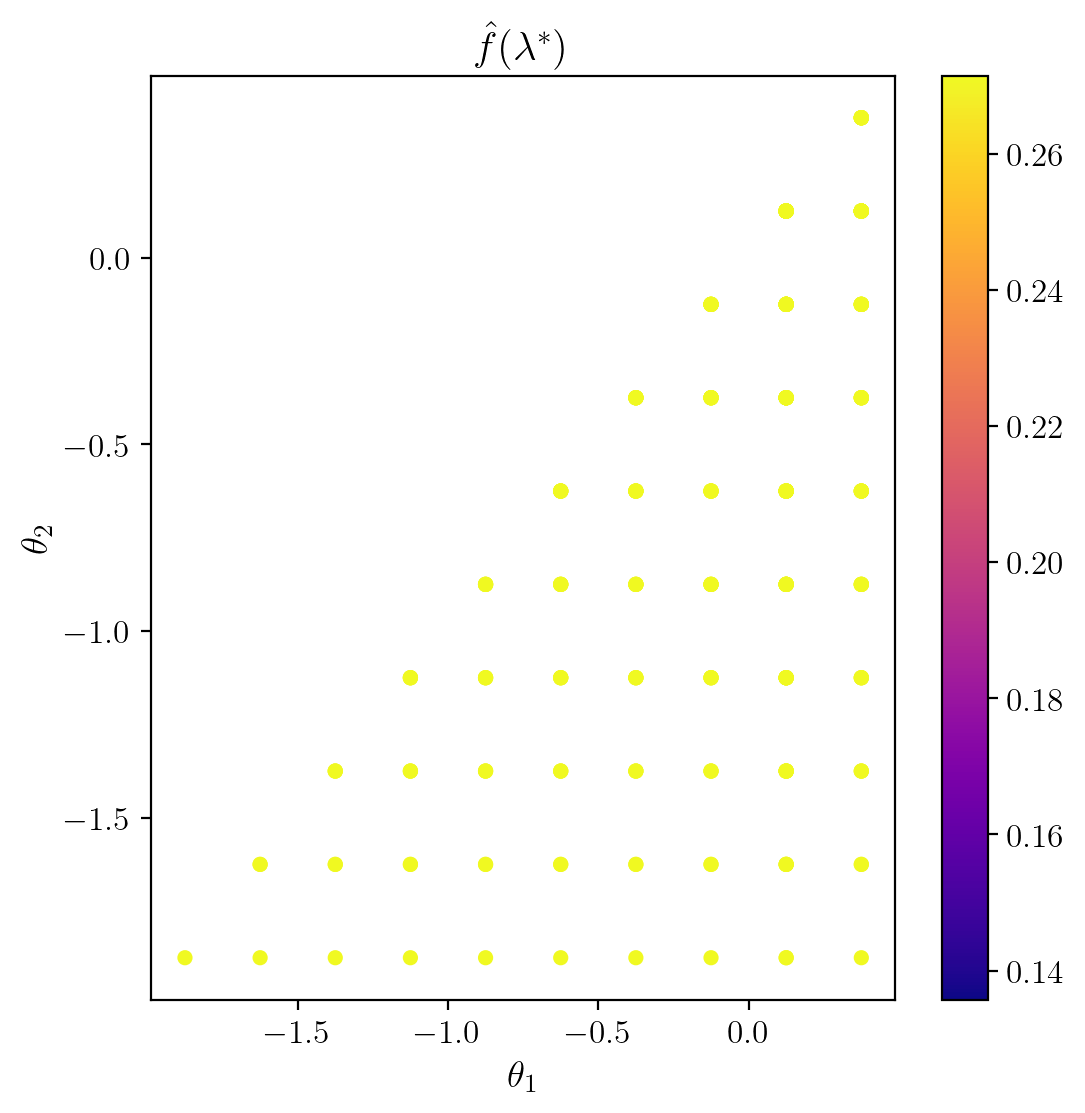

463


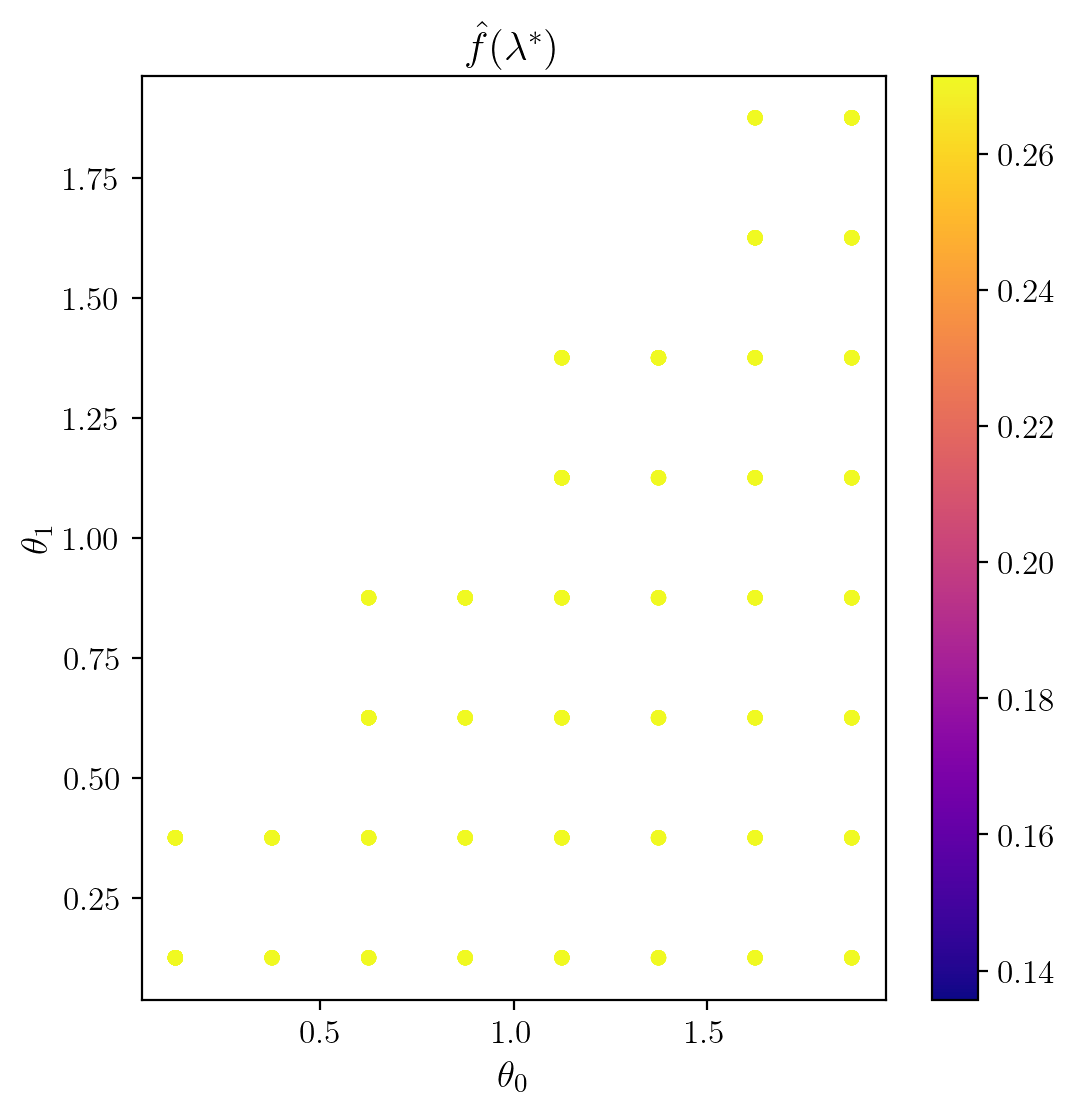

In [ ]:
for unplot in [0, 2]:
    plot = list({0, 1, 2} - {unplot})
    select = np.where(np.abs(g.theta_tiles[:, unplot] - worst_tile[unplot]) < 0.08)[0]

    ordered_select = select[np.argsort(sim_cvs[select])[::-1]]
    print(ordered_select.shape[0])

    plt.figure(figsize=(6, 6))
    plt.title(r"$\hat{f}(\lambda^{*})$")
    plt.scatter(
        g.theta_tiles[ordered_select, plot[0]],
        g.theta_tiles[ordered_select, plot[1]],
        c=sim_cvs[ordered_select],
        vmin=overall_cv,
        vmax=overall_cv * 2,
        s=20,
    )
    plt.colorbar()
    plt.xlabel(f"$\\theta_{plot[0]}$")
    plt.ylabel(f"$\\theta_{plot[1]}$")
    plt.show()

In [53]:
(2.0 / g.radii.min()) ** 3 / g.n_tiles

31442.172059354416

In [ ]:
# with open(f'checkpoint/6.pkl', 'rb') as f:
#     g, sim_sizes, sim_cvs, typeI_sum, hob_upper, pointwise_target_alpha = pickle.load(f)

# typeI_est, typeI_CI = binomial.zero_order_bound(
#     typeI_sum, sim_sizes, delta_validate, 1.0
# )
# typeI_bound = typeI_est + typeI_CI
# hob_upper = binomial.holder_odi_bound(
#     typeI_bound, g.theta_tiles, g.vertices, n_arm_samples, holderq
# )


# sim_cost = typeI_CI
# hob_theory_cost = target_alpha - pointwise_target_alpha
# hob_empirical_cost = hob_upper - typeI_bound

# worst_tile = np.argmin(sim_cvs)
# which_refine = (
#     hob_theory_cost > max(adafrac * hob_theory_cost[worst_tile], target_grid_cost)
# ) & (
#     (hob_upper > adafrac * hob_upper[worst_tile]) | (sim_cvs == sim_cvs[worst_tile])
# )
# which_more_sims = (
#     typeI_CI > max(adafrac * typeI_CI[worst_tile], target_sim_cost)
# ) & (
#     (typeI_bound > adafrac * hob_upper[worst_tile])
#     | (sim_cvs == sim_cvs[worst_tile])
# )

NameError: name 'adafrac' is not defined